In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import imodelsx.process_results
from collections import defaultdict
import numpy as np
import viz
import sys
sys.path.append('../experiments/')
results_dir = '/home/chansingh/mntv1/tree-prompt/mar18'
import notebook_helper

# r = imodelsx.process_results.get_results_df(results_dir)
# experiment_filename = '../experiments/01_fit.py'
# r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
# r['mean_llm_calls'] = notebook_helper.add_mean_llm_calls(r)
# r = r[r.model_name != 'manual_rf']
# r.to_pickle('../results/tprompt_results.pkl')

r = pd.read_pickle('../results/tprompt_results.pkl')
# r = r[r.num_data_demonstrations_per_class > 1]
ravg = r[r.seed == 1]

### Curves

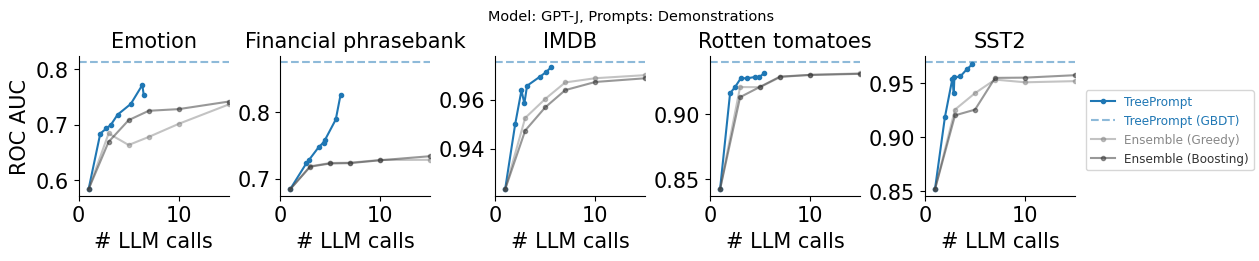

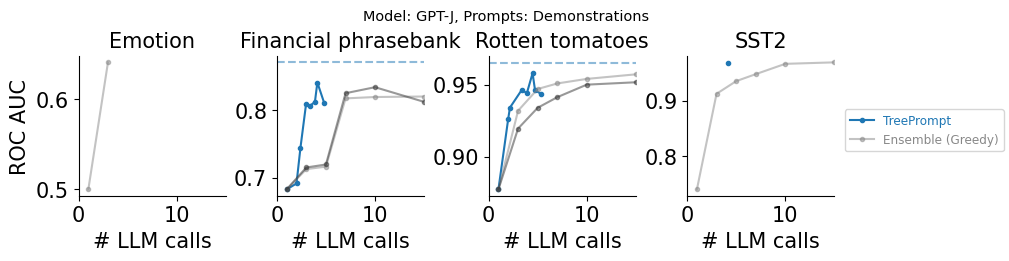

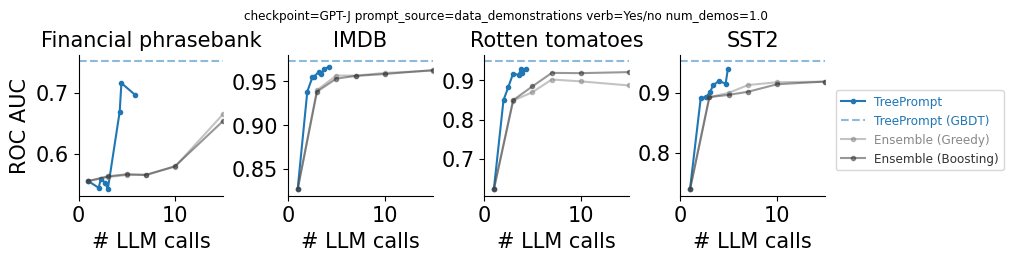

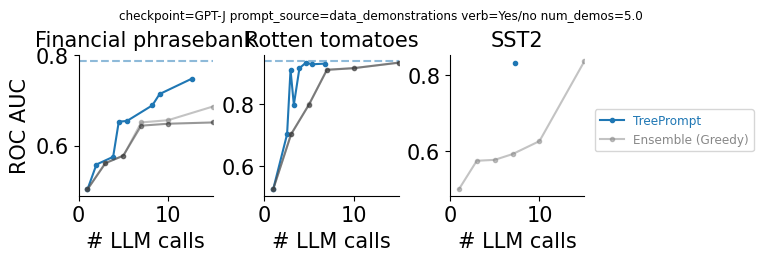

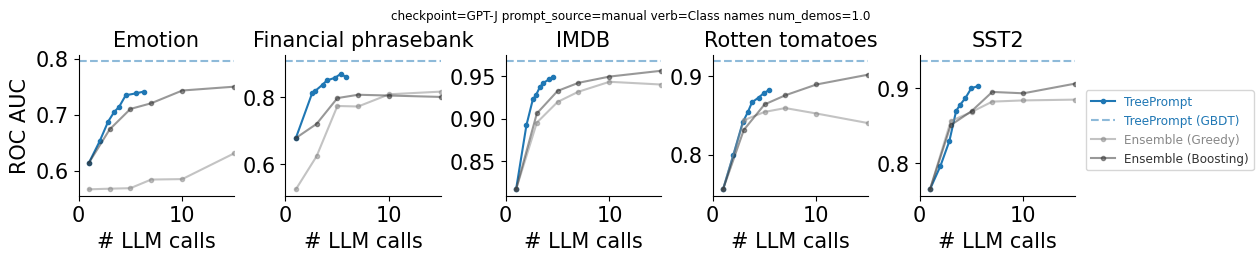

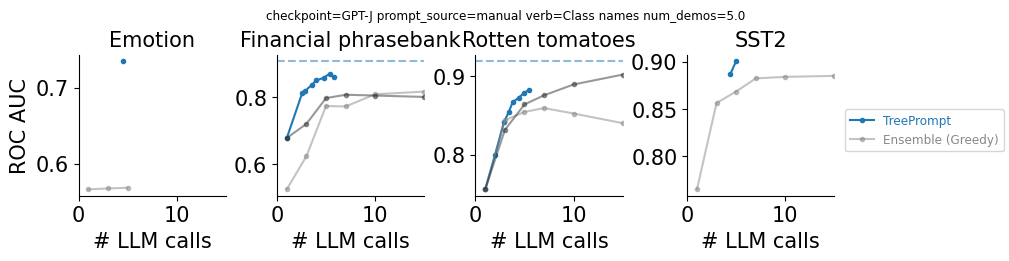

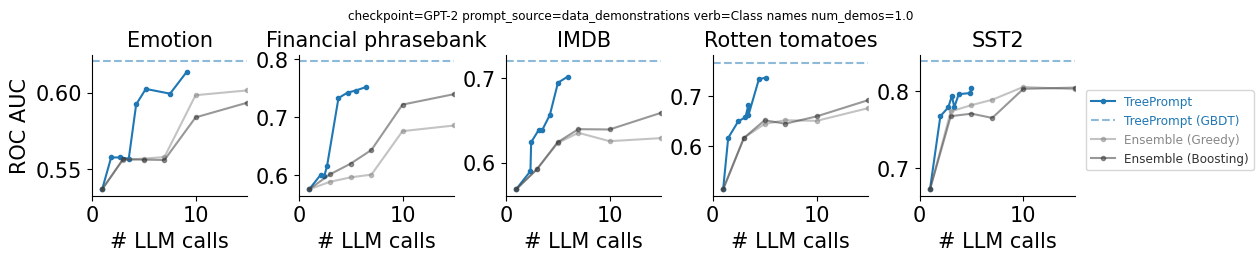

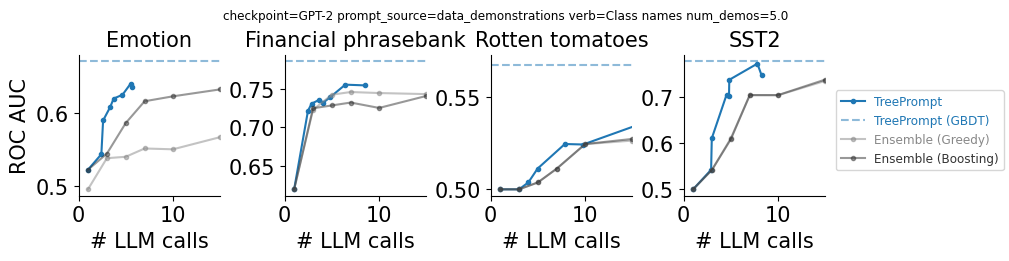

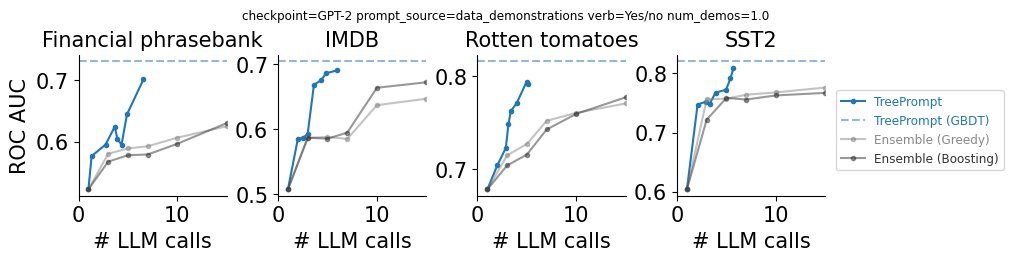

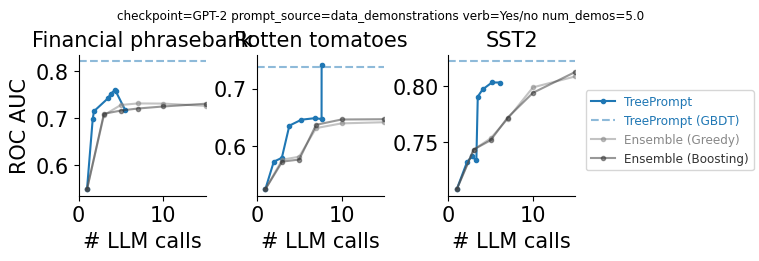

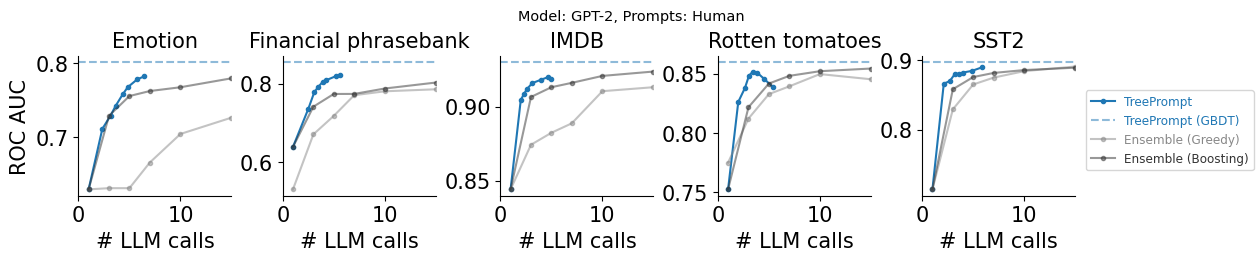

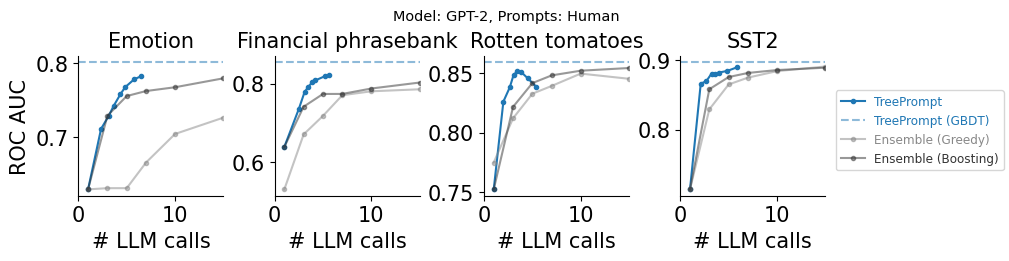

In [2]:
groupings = ['checkpoint', 'prompt_source', 'verbalizer_num', 'num_data_demonstrations_per_class'] #, 'binary_classification']
for k, rcurve in ravg.groupby(groupings):
    rcurve = rcurve.sort_values(by=['dataset_name', 'model_name', 'mean_llm_calls'])

    metric = 'roc_auc_test'
    # metric = 'accuracy'
    x = 'mean_llm_calls'                # x = 'num_prompts'

    viz.plot_perf_curves_individual(rcurve, x=x, xlim=15, metric=metric)
    x = rcurve.iloc[0]
    plt.suptitle(f'''checkpoint={viz.CHECKPOINTS_RENAME_DICT[x.checkpoint]} prompt_source={x.prompt_source} verb={viz.VERBS_RENAME_DICT[x.verbalizer_num]} num_demos={x.num_data_demonstrations_per_class}''', fontsize='xx-small')
    # plt.tight_layout()
    # plt.show()

    # save a couple
    row = rcurve.iloc[0]
    if row.checkpoint == 'EleutherAI/gpt-j-6B' and row.prompt_source == 'data_demonstrations' and row.verbalizer_num == 0:
        plt.suptitle(f'Model: {viz.CHECKPOINTS_RENAME_DICT[x.checkpoint]}, Prompts: {viz.SOURCE_RENAME_DICT.get(x.prompt_source, x.prompt_source)}', fontsize='x-small')
        plt.savefig('../results/figs/perf_curves_gptj.pdf', bbox_inches='tight')
    if row.checkpoint == 'gpt2' and row.prompt_source == 'manual' and row.verbalizer_num == 0:
        plt.suptitle(f'Model: {viz.CHECKPOINTS_RENAME_DICT[x.checkpoint]}, Prompts: {viz.SOURCE_RENAME_DICT.get(x.prompt_source, x.prompt_source)}', fontsize='x-small')
        plt.savefig('../results/figs/perf_curves_gpt2.pdf', bbox_inches='tight')

viz.save_figs_to_single_pdf("all_results.pdf")

### Table of results

In [ ]:
rd = ravg[ravg.num_data_demonstrations_per_class == 1]
groupings2 = ['checkpoint', 'prompt_source', 'verbalizer_num', 'dataset_name', 'model_name']

dset_names = rd.dataset_name.unique().tolist()
mets = defaultdict(list)
for k, rcurve in rd.groupby(groupings2):    
    # rcurve = rcurve.sort_values(by='accuracy_cv', ascending=False)
    # metadata
    for kk in groupings2:
        mets[kk].append(rcurve.iloc[0][kk])
    mets['roc_auc<=5'].append(rcurve[rcurve['mean_llm_calls'] <= 5]['roc_auc_test'].max())

df = pd.DataFrame.from_dict(mets)
df['dataset_name'] = df['dataset_name'].apply(viz.DSETS_RENAME_DICT_ABBR.get)
df['model_name'] = df['model_name'].apply(viz.MODELS_RENAME_DICT.get)
df['checkpoint'] = df['checkpoint'].apply(viz.CHECKPOINTS_RENAME_DICT.get)
df['prompt_source'] = df['prompt_source'].apply(viz.SOURCE_RENAME_DICT.get)
df['verbalizer_num'] = df['verbalizer_num'].apply(viz.VERBS_RENAME_DICT.get)
# df['prompt_source'] = df['prompt_source'].apply(viz.PROMPT_SOURCES_RENAME_DICT.get)
# print(df.style.hide().to_latex())
dfp = df.pivot_table(index=['dataset_name', 'checkpoint', 'prompt_source', 'verbalizer_num'], columns=['model_name'], values='roc_auc<=5').round(2)
print(dfp.style.format(precision=2, escape=True).to_latex(hrules=True).replace('NaN', '----').replace('_', ' '))

In [ ]:
print(
    "mean improvement",
    np.mean(dfp["TreePrompt"] - dfp["Ensemble (Boosting)"]),
    np.mean(dfp["TreePrompt"] - dfp["Ensemble (Greedy)"]),
)

### Choose best results

In [ ]:
# apply cross validation
ravg_cv = (
    ravg
    .sort_values(by='accuracy_cv', ascending=False)
    .groupby(by=['dataset_name', 'model_name', 'checkpoint'])
    .first()
    .reset_index()
)
ravg_cv

In [ ]:
rtab = ravg_cv[['dataset_name', 'model_name', 'checkpoint', 'accuracy_cv', 'accuracy_test']]
rtab = rtab.pivot_table(index=['checkpoint', 'model_name'], columns=['dataset_name'], values=['accuracy_test']).round(3)
rtab.columns = rtab.columns.get_level_values(1)

rtab

In [ ]:
print(rtab.style.format(precision=2).to_latex())